# Image Classification and Convolutional Neural Networks
## Cognitive Modeling  Summer 2024 Project

## Downloading EMNIST
To run below code we need to load the EMNIST's "test set" and we will use our pre-trained model/network from earlier. 

In [146]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
import os
import numpy as np
from scipy.spatial.distance import cosine
import random
import string
from PIL import Image

In [70]:
print('Loading EMNIST')

# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalization values can be adjusted based on the EMNIST dataset
])

# Load the EMNIST dataset
test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('data/',  # Specify your desired path
                    split='byclass',  # 'byclass' contains both digits and letters
                    train=False,      # Load the test dataset
                    download=True,
                    transform=transform),
    batch_size=1000, shuffle=True)

print('EMNIST has been loaded.')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Loading EMNIST
EMNIST has been loaded.
Using device: cpu


In [71]:
def number_to_char(num):
    if 0 <= num <= 9:
        return str(num)  # Return the number as a string
    elif 10 <= num <= 35:
        return chr(num + 55)  # Convert to uppercase letter ('A' starts at 65)
    elif 36 <= num <= 61:
        return chr(num + 61)  # Convert to lowercase letter ('a' starts at 97)
    else:
        return "Invalid input"  # Handle out of range inputs

## Convnet architecture for digit recognition
**First convolutional layer**: take an image (28x28 for EMNIST), and give 62 new images

**Second convolutional layer**: takes feature maps from 1st layer and gives 128 new feature maps

**Fully-connected layer**: fully-connected layer of 256 units and entire image is summarized with a vector of size 50 

**Output layer**: 62 units with one to represent each of the 10 digits + 26 uppercase + 26 lowercase letters and ses a softmax activation function, to ensure the network's predictions are a valid probability distribution

In [72]:
# Define the neural network model
class CNNModel(nn.Module):
    def __init__(self, num_classes=62):  # Change this to 62
        super(CNNModel, self).__init__()
        # Define the layers here
        self.conv1 = nn.Conv2d(1, num_classes, kernel_size=5)  # First convolutional layer
        self.conv2 = nn.Conv2d(num_classes, num_classes*2, kernel_size=5) # Second convolutional layer
        self.fc1 = nn.Linear(num_classes * 2 * 4 * 4, num_classes * 4)         # First fully-connected layer
        self.fc2 = nn.Linear(num_classes * 4, num_classes)        # Final ouptut layer
        self.num_classes = num_classes

    def forward(self, x):
        # first convolutional layer
        h_conv1 = self.conv1(x)
        h_conv1 = F.relu(h_conv1)
        h_conv1_pool = F.max_pool2d(h_conv1, 2)

        # second convolutional layer
        h_conv2 = self.conv2(h_conv1_pool)
        h_conv2 = F.relu(h_conv2)
        h_conv2_pool = F.max_pool2d(h_conv2, 2)

        # fully-connected layer
        h_fc1 = h_conv2_pool.view(-1, self.num_classes * 2 * 4 * 4)
        h_fc1 = self.fc1(h_fc1)
        h_fc1 = F.relu(h_fc1)

        # classifier output
        output = self.fc2(h_fc1)
        output = F.log_softmax(output,dim=1)
        return output, h_fc1, h_conv2, h_conv1
emnist_classes = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)

## Evaluating classification performance of the network
The code below will load our trained model and test the model's accuracy.

In [73]:
# Evaluate classification accuracy on the entire EMNIST test set
def test_model():
    correct = 0
    for data, target in test_loader:
        # run the data through the network
        output, _, _, _ = model(data)  # Adjusted to remove extra outputs
        # compare prediction to ground truth
        pred = torch.max(output, dim=1)[1]  # get the index of the max log-probability
        correct += torch.eq(pred, target.view_as(pred)).cpu().sum().item()
    perc_correct = 100. * correct / len(test_loader.dataset)
    return perc_correct

# Show the network's predicted class for an arbitrary set of `nshow` images from the EMNIST test set
def test_viz(nshow=10):
    testiter = iter(test_loader)
    images, target = next(testiter)
    perm = np.random.permutation(images.shape[0])
    data = images[perm[:nshow]]
    
    output, _, _, _ = model(data)
    pred = torch.max(output, dim=1)[1]
    pred = pred.numpy().flatten()
    
    for i in range(nshow):
        ax = plt.subplot(1, nshow, i + 1)
        imshow(utils.make_grid(data[i]))
        if pred[i] < len(emnist_classes):
            plt.title(emnist_classes[pred[i]])
        else:
            plt.title('Unknown')
        
# Display an image from the EMNIST data set
def imshow(img):
    img = 1 - (img * 0.5 + 0.5)  # Invert the normalization if needed
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))  # Transpose dimensions for correct orientation
    npimg = np.rot90(npimg, k=1)  # Rotate the image counterclockwise (adjust k as needed)
    npimg = np.flipud(npimg)
    plt.imshow(npimg, cmap='gray')
    plt.axis('off')

Convnet has been loaded successfull.
Number of classes: 62
Running through the test set...
Accuracy on the test set is 86.13 percent correct!

The images are shown below their predicted class labels.


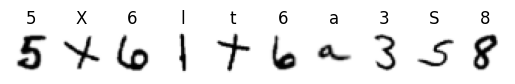

In [74]:
# Loading the model
model = CNNModel()
model.load_state_dict(torch.load('training/emnist_cnn_model.pt', weights_only=False, map_location=device))
model.eval()
print('Convnet has been loaded successfull.')
print(f'Number of classes: {len(emnist_classes)}')

print('Running through the test set...')
test_acc = test_model()
print('Accuracy on the test set is %.2f percent correct!' % test_acc)
print("")
print("The images are shown below their predicted class labels.")
test_viz()

## Selecting digits and letters for similarity analysis
We are going to generate a set of random letters and digits pairs from a particular image class and evaluate these images on the EMNIST test set.

In [153]:
def get_random_subset(class_select_list, npairs=20):
    testiter = iter(test_loader)
    images, target = next(testiter)
    
    initial_npairs = npairs
    
    images1_list = []
    images2_list = []
    
    for class_select in class_select_list:
        indices = np.flatnonzero(target.numpy() == class_select)
        
        while len(indices) < 2 * initial_npairs:
            initial_npairs -= 1
        
        np.random.shuffle(indices)
        
        indx1 = torch.tensor(indices[:initial_npairs], dtype=torch.long)
        indx2 = torch.tensor(indices[initial_npairs:initial_npairs*2], dtype=torch.long)
        images1 = images[indx1]
        images2 = images[indx2]
        
        images1_list.append(images1)
        images2_list.append(images2)
        
        plt.figure(figsize=(8, initial_npairs * 2))
        plot_image_pairs(images1, images2, class_name=class_select)
        plt.show()
        initial_npairs = npairs

    return images1_list, images2_list

def plot_image_pairs(images1, images2, scores_net=[], scores_people=[], save_dir='images/', class_name=''):
    npairs = images1.size()[0]
    assert images2.size()[0] == npairs
    
    for i in range(npairs):
        ax1 = plt.subplot(npairs, 2, 2*i + 1)
        imshow(utils.make_grid(images1[i:i+1]))
        plt.axis('off')
        
        ax2 = plt.subplot(npairs, 2, 2*i + 2)
        imshow(utils.make_grid(images2[i:i+1]))
        plt.axis('off')
        
        mytitle = ''
        if len(scores_net) > 0:
            mytitle += 'net %.2f, ' % scores_net[i] 
        if len(scores_people) > 0:
            mytitle += 'human %.2f' % scores_people[i]
        
        if mytitle:
            ax1.set_title(mytitle)
    # Define the filename
    filename = os.path.join(save_dir, f'image_pair_{number_to_char(class_name)}.png')
    try:
        # Save each pair as a separate file
        print(f'Saving file: {filename}')
        plt.savefig(filename)
    except Exception as e:
        print(f'Error saving file {filename}: {e}')
            
def check_class_distribution(target):
    unique, counts = np.unique(target.numpy(), return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"Class {cls} has {count} samples.")

Code for generating multiple different image pairs of different digits and letters.

Saving file: images/image_pair_e.png


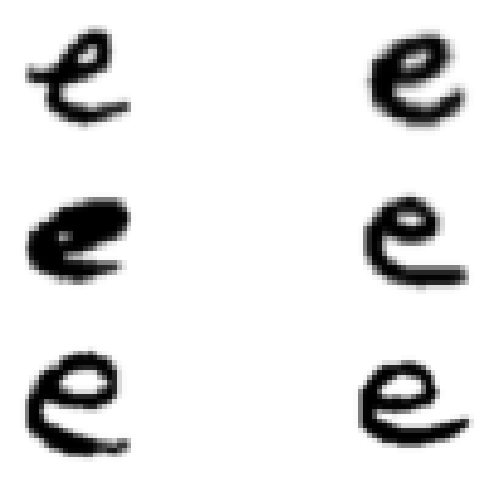

Saving file: images/image_pair_M.png


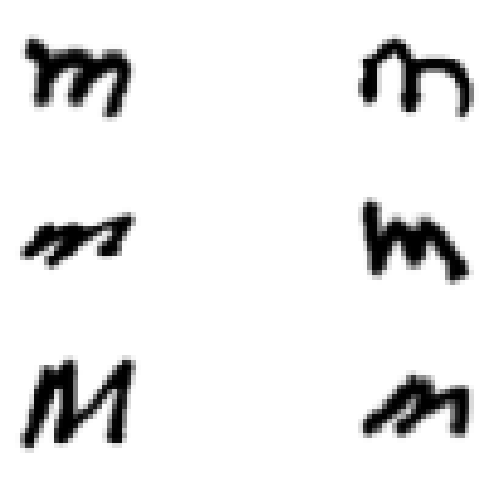

Saving file: images/image_pair_3.png


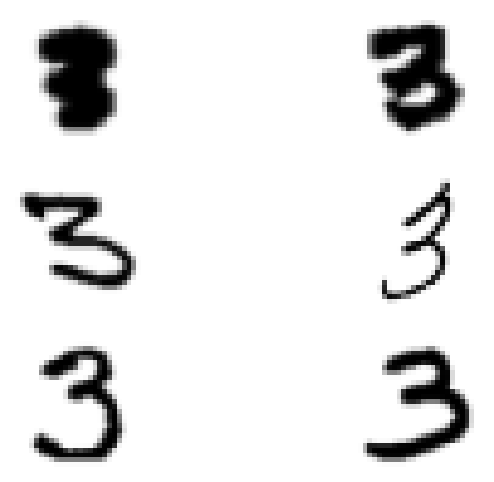

Saving file: images/image_pair_U.png


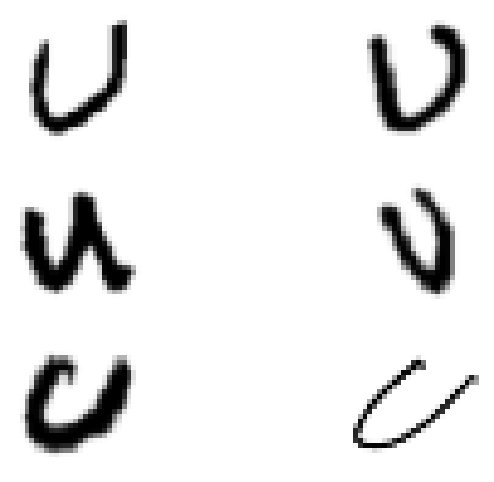

In [154]:
# testiter = iter(test_loader)
# _, target = next(testiter)
# check_class_distribution(target)

test_list = [40, 22, 3, 30]
images1_list, images2_list = get_random_subset(class_select_list=test_list, npairs=3)

## Computing similarity judgments with the network
To get predictions from the network, we use the hidden representation of an image at a particular layer to compute high-level features. We then compare these features using cosine similarity, which measures the angle between two vectors to assess the similarity between patterns of activation.

In [155]:
# Re-scale a vector to have a minimum value of 0 and a maximum of 1
def normalize(v):
    v = v - v.min()
    v = v / v.max()
    return v

# Compute convnet similarity for each pair of images
def get_sim_judgments(images1, images2, layer='fc'):
    N = images1.size()[0]  # Number of pairs
    assert N == images2.size()[0]
    
    # Pass images through the model to get intermediate layers
    output_1, h_fc1_1, h_conv2_1, h_conv1_1 = model(images1)
    output_2, h_fc1_2, h_conv2_2, h_conv1_2 = model(images2)
    
    # Grab the tensors from the appropriate layer
    if layer == 'fc':
        T1 = h_fc1_1
        T2 = h_fc1_2
    elif layer == 'conv1':
        T1 = h_conv1_1
        T2 = h_conv1_2
    elif layer == 'conv2':
        T1 = h_conv2_1
        T2 = h_conv2_2
    else:
        raise Exception('Layer parameter has unrecognized value')
    
    # Flatten the tensors for each image
    T1 = T1.detach().numpy().reshape(N, -1)
    T2 = T2.detach().numpy().reshape(N, -1)

    v_sim = np.zeros(N)
    for i in range(N):  # For each pair
        v1 = T1[i, :]
        v2 = T2[i, :]
        v_sim[i] = 1 - cosine(v1, v2)  # Using cosine distance

    return v_sim

## Rating the image pairs
1. Get judgments from the network: done by using get_sim_judgments methods
2. Get judgments from people: ask x people to rate each image on a scale of 1 (least similar) to 10 (most similar)

In [156]:
def find_score(image):
    image_score = 0
    index_count = 0
    dem = 10.0000
    for i in image:
        try: 
            for j in i:
                image_score += j
                index_count += 1
                dem = 10.0000000
        except TypeError: 
            image_score += i
            index_count += 1
            dem = 1.0000000
    return ( image_score / index_count ) / dem

In [157]:
all_v_sim_net = []

# our friends rated above images
image_1_human_rating = [[3, 2, 3, 4, 1, 2, 3, 2], [1, 2, 1, 3, 2, 2, 3, 1], [4, 4, 3, 5, 6, 6, 7, 2]]
image_2_human_rating = [[7, 3, 6, 4, 5, 6, 6, 4], [6, 4, 6, 5, 7, 8, 4, 5], [9, 8, 9, 7, 6, 7, 8, 9]]
image_3_human_rating = [[6, 5, 7, 6, 8, 4, 5, 6], [7, 5, 6, 4, 6, 7, 5, 8], [2, 5, 6, 4, 7, 5, 5, 5]]
image_4_human_rating = [[10, 9, 7, 8, 9, 9, 9, 8], [10, 9, 9, 8, 9, 10, 9, 10], [3, 4, 5, 8, 4, 7, 6, 5]]


all_human_ratings = [find_score(image_1_human_rating), find_score(image_2_human_rating), find_score(image_3_human_rating), find_score(image_4_human_rating)]

index = 0
for i, j in zip(images1_list, images2_list):
    v_sim_net = get_sim_judgments(i, j, 'fc')
    print(f"Model similarity rating for {test_list[index]}: {v_sim_net}")
    index += 1
    all_v_sim_net.append(find_score(v_sim_net))

Model similarity rating for 40: [0.80808475 0.62705463 0.65358712]
Model similarity rating for 22: [0.76346348 0.71994489 0.7924206 ]
Model similarity rating for 3: [0.6153955  0.54813055 0.81173378]
Model similarity rating for 30: [0.68325126 0.37719533 0.45140999]


## Compare the Similarities
Compute the correlation coefficient and graph using a bar graph

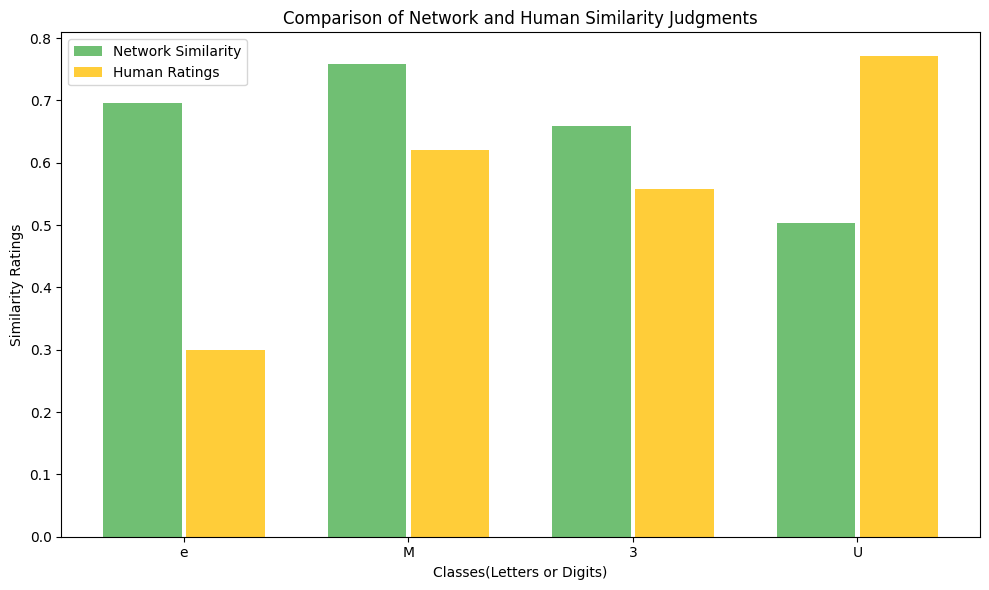

In [158]:
# Prepare data for histogram
n_classes = len(test_list)
width = 0.35  # Width of the bars
opacity = 0.8

# Plotting histogram
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(n_classes)

# Create bars for neural network similarity ratings
bars1 = ax.bar(x - (width/2 + 0.01), all_v_sim_net, width,
               alpha=opacity, color='#4CAF50', label='Network Similarity')

# Create bars for human similarity ratings
bars2 = ax.bar(x + (width/2 + 0.01), all_human_ratings, width,
               alpha=opacity, color='#FFC107', label='Human Ratings')

# Convert x labels from numbers to character values
x_labels = [number_to_char(i) for i in test_list]

# Adding labels
ax.set_xlabel('Classes(Letters or Digits)')
ax.set_ylabel('Similarity Ratings')
ax.set_title('Comparison of Network and Human Similarity Judgments')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

plt.tight_layout()
plt.show()